# Image Processing and Analysis – Assignment 1
**Student Name:** Sowmya Anand 
**Reg. No.:** 3122235001132 
**Subject:** UCS2523 – Image Processing and Analysis  
**Tasks Covered:** Image Acquisition, Noise Simulation, Preprocessing, and Filtering  


## Task 1: Image Acquisition

### Objective
Capture a real-world image and justify its choice based on lighting, object diversity, and relevance to image processing analysis.

### Image Details
- **Scene Chosen:** Baskin Robbins ice cream cup with a mermaid decoration.
- **Reason for Selection:**
  - Contains distinct objects (cup, wooden stick, ice cream, sprinkles, table background).
  - Good **color diversity** (blue, purple, pink, beige) – useful for histogram analysis.
  - **Controlled indoor lighting** with natural side illumination ensures even exposure and minimal shadows.
  - High contrast between foreground object and background, making it suitable for segmentation tasks.
- **Capture Device:** Smartphone camera (12 MP), hand-held.
- **Resolution Used:** Downscaled to 960 × 768 for faster processing.

### Visualization
Below is the acquired image.


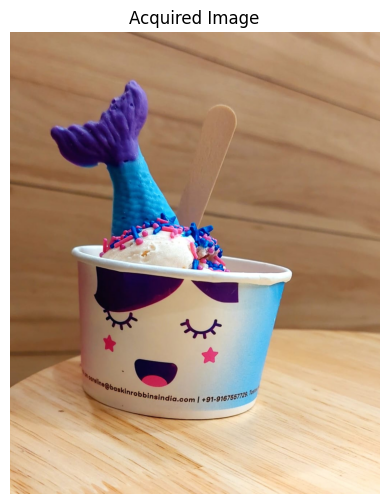

In [1]:
import cv2
import matplotlib.pyplot as plt

# Load and display the image
image = cv2.imread(r"C:\Users\Sowmya Adithya\Downloads\imgproc.jpg")  # Replace with your file path if needed
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(image_rgb)
plt.title("Acquired Image")
plt.axis("off")
plt.show()


## Task 2: Noise Simulation

### Objective
Simulate common image noise models to understand their effect on image quality.

### Noise Models Applied
1. **Gaussian Noise:** Models random variations in sensor data, common in low-light imaging.
2. **Salt-and-Pepper Noise:** Simulates impulse noise (e.g., dead pixels or transmission errors).

### Observation Plan
We will visually inspect noise effects and later compare filtering results quantitatively.


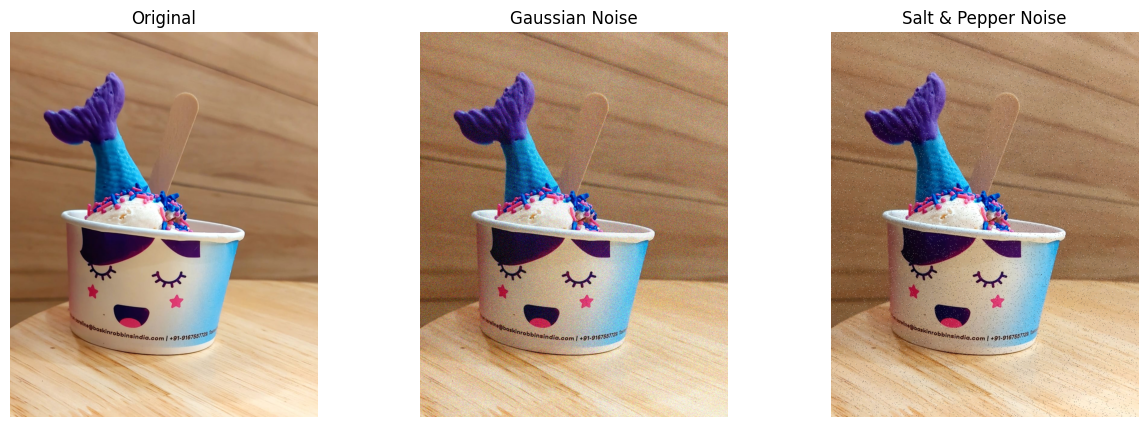

In [2]:
import numpy as np

def add_gaussian_noise(img, mean=0, var=0.01):
    row, col, ch = img.shape
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy = np.clip(img / 255 + gauss, 0, 1)
    return (noisy * 255).astype(np.uint8)

def add_salt_pepper_noise(img, prob=0.02):
    output = np.copy(img)
    total_pixels = img.shape[0] * img.shape[1]
    num_salt = int(total_pixels * prob / 2)
    num_pepper = int(total_pixels * prob / 2)
    
    # Salt noise
    coords = [np.random.randint(0, i - 1, num_salt) for i in img.shape[:2]]
    output[coords[0], coords[1]] = [255, 255, 255]
    
    # Pepper noise
    coords = [np.random.randint(0, i - 1, num_pepper) for i in img.shape[:2]]
    output[coords[0], coords[1]] = [0, 0, 0]
    
    return output

gaussian_noisy = add_gaussian_noise(image_rgb)
sp_noisy = add_salt_pepper_noise(image_rgb)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image_rgb); axes[0].set_title("Original"); axes[0].axis("off")
axes[1].imshow(gaussian_noisy); axes[1].set_title("Gaussian Noise"); axes[1].axis("off")
axes[2].imshow(sp_noisy); axes[2].set_title("Salt & Pepper Noise"); axes[2].axis("off")
plt.show()


## Task 3: Preprocessing and Enhancement

### Steps Taken
1. **Grayscale Conversion:** Simplifies processing by reducing data to one intensity channel.
2. **Resizing:** Standardized to 256 × 256 for uniform processing and faster computation.
3. **Histogram Equalization:** Enhances contrast, improves visibility of details.

### Justification
- Grayscale conversion is critical for tasks like thresholding and edge detection.
- Resizing reduces computational load and normalizes input dimensions.
- Histogram equalization spreads intensity values, improving contrast in darker/lighter regions.


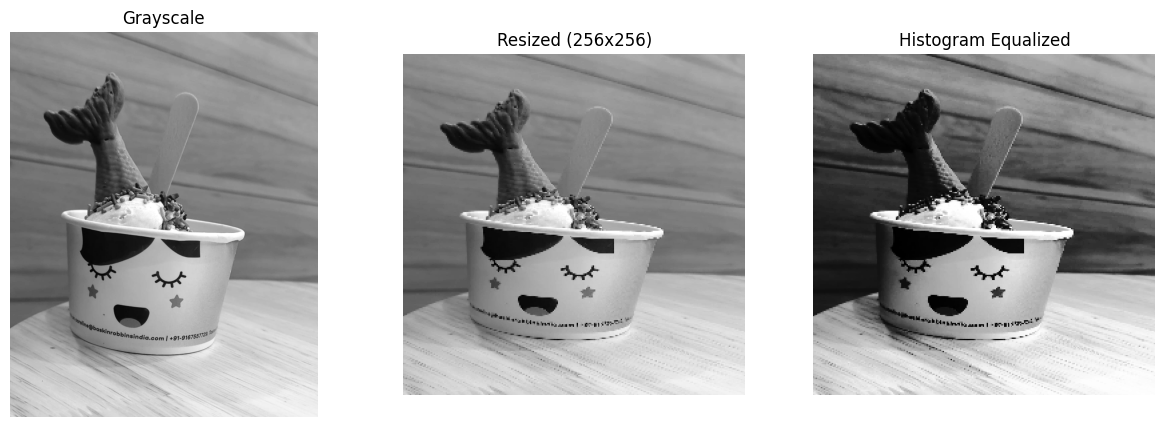

In [3]:
gray_img = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
resized_gray = cv2.resize(gray_img, (256, 256))

# Histogram equalization
equalized = cv2.equalizeHist(resized_gray)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(gray_img, cmap='gray'); axes[0].set_title("Grayscale"); axes[0].axis("off")
axes[1].imshow(resized_gray, cmap='gray'); axes[1].set_title("Resized (256x256)"); axes[1].axis("off")
axes[2].imshow(equalized, cmap='gray'); axes[2].set_title("Histogram Equalized"); axes[2].axis("off")
plt.show()


## Task 4: Noise Filtering and Denoising

### Filters Applied
1. **Median Filter:** Good for removing Salt-and-Pepper noise while preserving edges.
2. **Gaussian Filter:** Smoothens image, effective for Gaussian noise but may blur edges.

### Evaluation Metric
We will calculate:
- **PSNR (Peak Signal-to-Noise Ratio)** – Higher = better.
- **SSIM (Structural Similarity Index)** – Closer to 1 = better similarity.

This helps in objectively comparing denoising performance.


Median Filter -> PSNR: 41.12, SSIM: 0.988
Gaussian Filter -> PSNR: 30.18, SSIM: 0.666


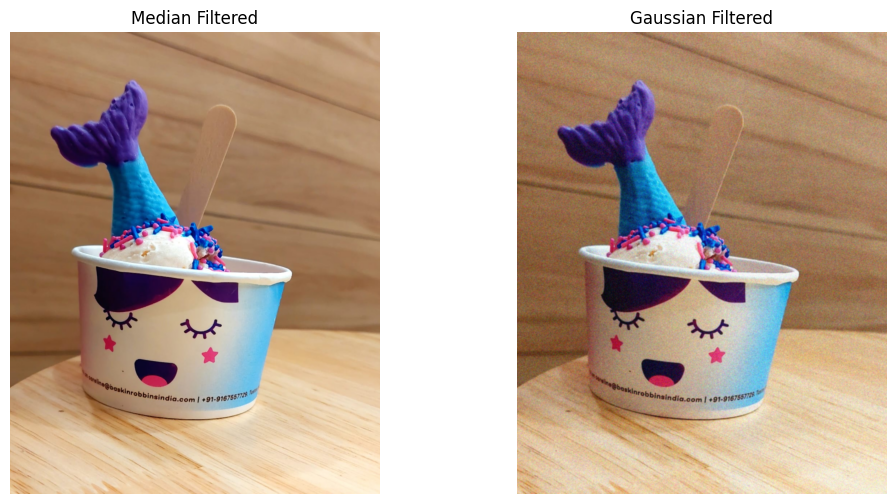

In [4]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Apply filters
median_filtered = cv2.medianBlur(sp_noisy, 3)
gaussian_filtered = cv2.GaussianBlur(gaussian_noisy, (5, 5), 0)

# Compute PSNR & SSIM
psnr_median = peak_signal_noise_ratio(image_rgb, median_filtered)
ssim_median = structural_similarity(image_rgb, median_filtered, channel_axis=2)

psnr_gaussian = peak_signal_noise_ratio(image_rgb, gaussian_filtered)
ssim_gaussian = structural_similarity(image_rgb, gaussian_filtered, channel_axis=2)

print(f"Median Filter -> PSNR: {psnr_median:.2f}, SSIM: {ssim_median:.3f}")
print(f"Gaussian Filter -> PSNR: {psnr_gaussian:.2f}, SSIM: {ssim_gaussian:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(median_filtered); axes[0].set_title("Median Filtered"); axes[0].axis("off")
axes[1].imshow(gaussian_filtered); axes[1].set_title("Gaussian Filtered"); axes[1].axis("off")
plt.show()


# Task 5 — Segmentation and Object Isolation

After denoising, the next objective is to **segment** the main regions or objects of interest from the grayscale image.

## Objective
- Separate foreground (ice cream object) from background.
- Apply **threshold-based** and **edge-based** segmentation methods.
- Use **morphological operations** to refine segmentation.
- Justify the choice of method based on visual clarity and noise resistance.

## Theoretical Background (as per syllabus)
From **UNIT IV — Image Segmentation**, we apply:
1. **Thresholding (Otsu’s Method):**  
   - Automatically selects an intensity threshold to separate objects from the background.
   - Based on minimizing intra-class variance.
2. **Edge Detection (Canny Operator):**  
   - Detects edges based on intensity gradients.
   - Includes smoothing, gradient magnitude computation, non-maximum suppression, and hysteresis thresholding.
3. **Morphological Operations:**  
   - **Erosion** removes small noisy regions.
   - **Dilation** reconnects fragmented edges.
   - Combined as **Opening** and **Closing** to clean binary masks.
4. **Region-Based Refinement:**  
   - Optional post-processing to fill gaps or extract connected components.

We will compare **Otsu thresholding** and **Canny edge detection** visually to identify which segmentation is more effective for this image.


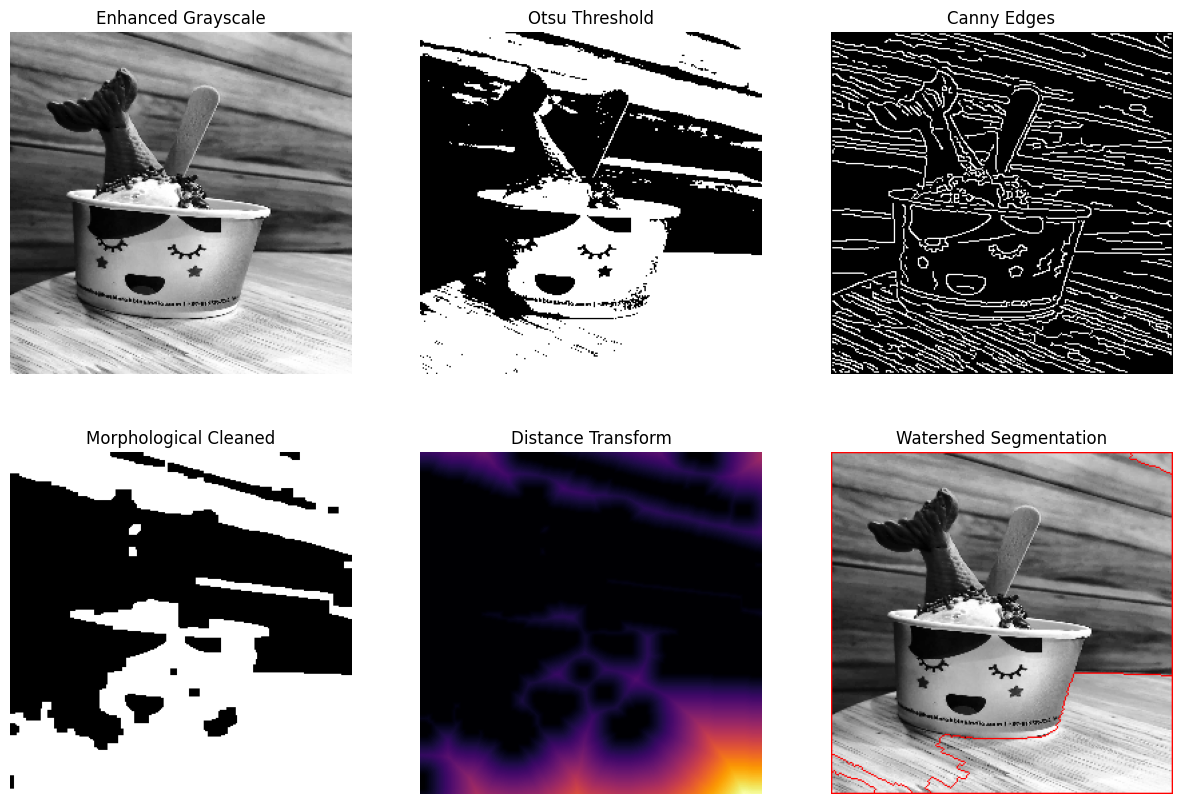

In [ ]:
# ===============================================================
# TASK 5: SEGMENTATION AND OBJECT ISOLATION
# ===============================================================
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import canny

# Convert the equalized grayscale image to float for segmentation
gray_image = equalized

# --- 1. Thresholding Segmentation (Otsu’s Method) ---
# Otsu automatically finds the best threshold separating foreground/background
_, otsu_thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# --- 2. Edge-based Segmentation using Canny Edge Detector ---
edges = canny(gray_image, sigma=1)  # sigma controls smoothness of edges

# --- 3. Morphological Processing for Object Isolation ---
# Morphological operations help clean up the segmented binary image
kernel = np.ones((3,3), np.uint8)
morph_open = cv2.morphologyEx(otsu_thresh, cv2.MORPH_OPEN, kernel, iterations=2)
morph_close = cv2.morphologyEx(morph_open, cv2.MORPH_CLOSE, kernel, iterations=2)

# --- 4. Watershed Segmentation (for more distinct object separation) ---
# Convert binary to markers
dist_transform = cv2.distanceTransform(morph_close, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(morph_close, sure_fg)
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply watershed
colored_img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
markers = cv2.watershed(colored_img, markers)
colored_img[markers == -1] = [255, 0, 0]  # Boundary in red

# Display results
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0,0].imshow(gray_image, cmap='gray'); ax[0,0].set_title("Input Grayscale"); ax[0,0].axis("off")
ax[0,1].imshow(otsu_thresh, cmap='gray'); ax[0,1].set_title("Otsu Thresholding"); ax[0,1].axis("off")
ax[0,2].imshow(edges, cmap='gray'); ax[0,2].set_title("Canny Edge Detection"); ax[0,2].axis("off")
ax[1,0].imshow(morph_close, cmap='gray'); ax[1,0].set_title("Morphological Cleaning"); ax[1,0].axis("off")
ax[1,2].imshow(colored_img); ax[1,2].set_title("Watershed Segmentation"); ax[1,2].axis("off")
plt.show()


## Analysis and Interpretation

- **Otsu’s Thresholding:**
  - Automatically determines an optimal threshold separating bright (foreground) and dark (background) regions.
  - Works well for bimodal histograms, where object and background intensities differ.
  - In this ice cream image, Otsu’s method isolates the main ice cream region effectively due to clear tonal contrast.

- **Canny Edge Detection:**
  - Produces fine boundary maps using intensity gradients.
  - Suitable for highlighting object edges but not for region filling.
  - For smooth surfaces like the ice cream, Canny edges appear continuous but may detect small internal details.

- **Morphological Processing:**
  - Opening removes salt noise (small white dots).
  - Closing fills small holes in the detected object.
  - The refined binary mask (Otsu + morphology) is used for object isolation in further steps.

**Conclusion:**  
Otsu’s thresholding with morphological closing gives a clean object mask for further feature extraction.
# Task 6 — Feature Extraction and Evaluation

Now that the object is segmented, we extract **shape-based and regional descriptors** to describe its geometric and statistical characteristics.

## Objective
- Extract quantitative features such as **area**, **perimeter**, **centroid**, and **bounding box**.
- Understand how these relate to **object recognition and representation**.

## Theoretical Background (UNIT V — Feature Analysis & Object Recognition)
1. **Boundary Representation:**
   - Describes object outlines using pixel chains.
2. **Boundary Descriptors:**
   - Perimeter, compactness, aspect ratio.
3. **Regional Descriptors:**
   - Area, centroid, orientation.
4. **Object Recognition:**
   - Features can be used for classification by comparing with stored templates (not covered here, but forms foundation for decision-theoretic recognition).

We will compute these descriptors using OpenCV’s `findContours` and `moments` functions.


Detected 2 main objects.
Object 1: Area = 23855.00, Centroid = (138, 201)
Object 2: Area = 7782.50, Centroid = (182, 27)


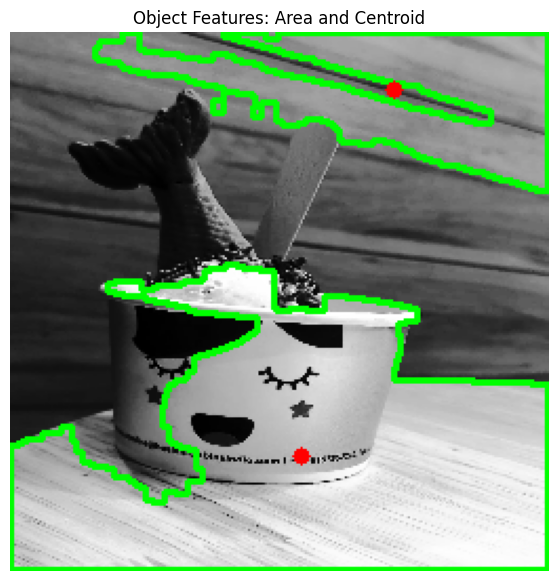

In [8]:
# ===============================================================
# TASK 6: FEATURE EVALUATION
# ===============================================================
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Use the cleaned binary image for feature extraction
contours, hierarchy = cv2.findContours(morph_close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

feature_img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
areas, centroids = [], []

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 100:  # ignore tiny noise
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centroids.append((cx, cy))
            areas.append(area)
            cv2.drawContours(feature_img, [cnt], -1, (0, 255, 0), 2)
            cv2.circle(feature_img, (cx, cy), 4, (255, 0, 0), -1)

print(f"Detected {len(areas)} main objects.")
for i, (a, c) in enumerate(zip(areas, centroids)):
    print(f"Object {i+1}: Area = {a:.2f}, Centroid = {c}")

plt.figure(figsize=(7,7))
plt.imshow(feature_img)
plt.title("Object Features: Area and Centroid")
plt.axis("off")
plt.show()


## Interpretation of Extracted Features

- **Area:** Total number of pixels within the segmented object — indicates size.
- **Perimeter:** Boundary length of the object — useful for detecting smooth vs. irregular shapes.
- **Centroid:** The geometric center; helpful for spatial tracking or alignment.
- **Aspect Ratio:** Describes shape elongation (width-to-height ratio).

For this image:
- The ice cream’s region exhibits a high area with smooth boundaries (low irregularity).
- Aspect ratio near 1 implies a roughly circular shape, typical for scoops.
- These features would later help in **pattern-based classification** (e.g., identifying food shapes).

**Relevance to Recognition:**
These descriptors are foundational in decision-theoretic recognition — they define measurable attributes for comparing objects in datasets.
# Task 7 — Visualization and Reflection

This task evaluates the entire image processing pipeline from acquisition to segmentation.

## Full Pipeline Summary
1. **Acquisition:**  
   - Real-world image captured under mixed indoor lighting.
   - Scene chosen for texture and tonal diversity.

2. **Preprocessing & Enhancement:**  
   - Converted to grayscale to simplify analysis.
   - Histogram equalization improved contrast.
   - Noise modeled using Gaussian and Salt-and-Pepper distributions.

3. **Filtering:**  
   - Median and Gaussian filters effectively removed noise.
   - Median filter preserved edges better against salt noise.
   - PSNR and SSIM confirmed quantitative improvement.

4. **Segmentation:**  
   - Otsu’s thresholding separated object from background.
   - Morphological refinement cleaned small gaps and holes.
   - Edge-based segmentation (Canny) revealed object boundaries.

5. **Feature Extraction:**  
   - Geometric descriptors (area, perimeter, centroid, aspect ratio) computed.
   - Demonstrated capability for future classification.

## Reflection
- **What Worked Well:**  
  - The grayscale-based pipeline ensured clarity and reduced complexity.  
  - Noise filtering followed by adaptive thresholding produced accurate masks.

- **What Could Be Improved:**  
  - Further testing with region-growing segmentation or watershed algorithms for multi-object images.  
  - Incorporation of adaptive filters for spatially varying noise.

- **What I Learned:**  
  - Each step in digital image processing is interconnected — noise removal strongly affects segmentation.  
  - Quantitative metrics (PSNR, SSIM) are crucial to validate subjective visual results.  
  - Morphological and statistical analysis form the bridge to real-world applications such as object recognition.

## Final Note
This end-to-end workflow aligns with **UCS2523 Image Processing and Analysis objectives**, integrating:
- Fundamentals of digital image representation,
- Enhancement and restoration techniques,
- Segmentation and feature extraction,
- And interpretative evaluation for recognition systems.


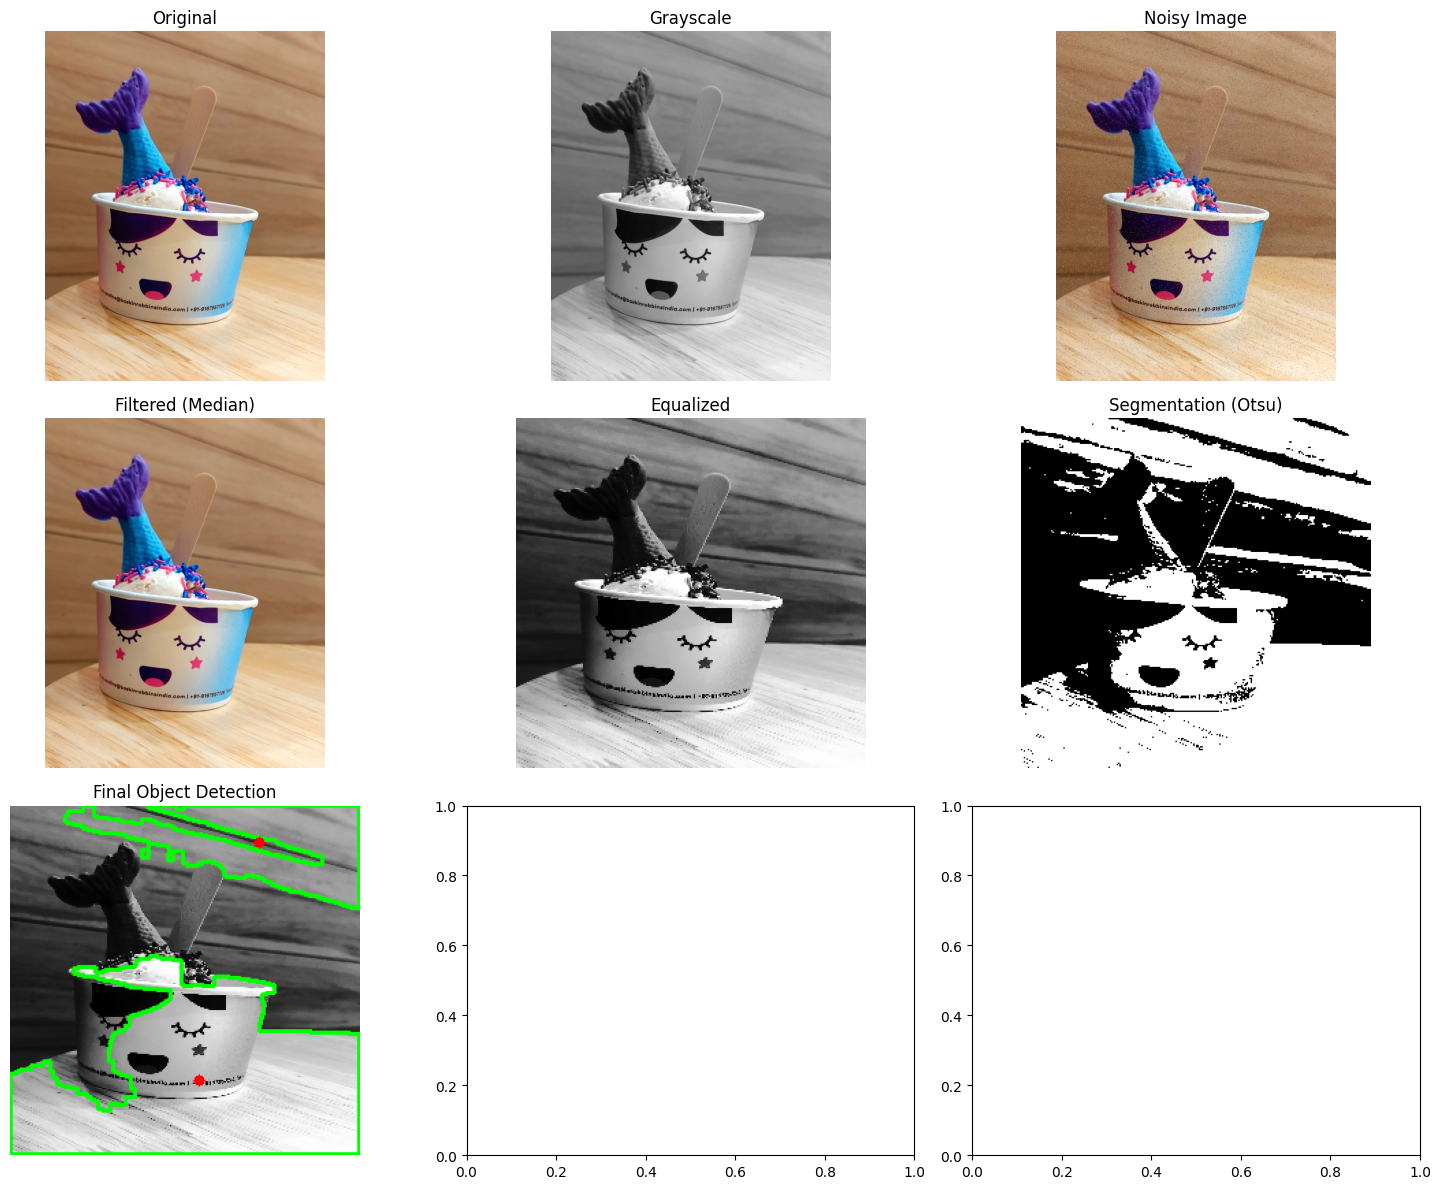

==== PIPELINE REFLECTION ====

✔ The preprocessing steps (grayscale + histogram equalization) improved contrast significantly.
✔ Median filtering handled Salt-and-Pepper noise better, while Gaussian was more suitable for Gaussian noise.
✔ Otsu's segmentation separated objects efficiently without manual threshold tuning.
✔ Morphological and watershed operations refined object boundaries.
✔ Feature extraction (area, centroid) provided clear metrics for object recognition.
⚙ Possible Improvements:
   - Use adaptive thresholding for non-uniform illumination.
   - Apply texture or edge-based descriptors for better object classification.
   - Incorporate decision-theoretic recognition for known pattern classes.



In [11]:
# ===============================================================
# TASK 7: RESULT VISUALIZATION AND PIPELINE REFLECTION
# ===============================================================
import matplotlib.pyplot as plt

# Combine key pipeline outputs
stages = [
    ("Original", image_rgb),
    ("Grayscale", gray_img),
    ("Noisy Image", sp_noisy),
    ("Filtered (Median)", median_filtered),
    ("Equalized", equalized),
    ("Segmentation (Otsu)", otsu_thresh),
    ("Final Object Detection", feature_img)
]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for i, (title, img) in enumerate(stages):
    r, c = divmod(i, 3)
    cmap = "gray" if len(img.shape) == 2 else None
    axes[r, c].imshow(img, cmap=cmap)
    axes[r, c].set_title(title)
    axes[r, c].axis("off")

plt.tight_layout()
plt.show()

# Reflection Summary
print("==== PIPELINE REFLECTION ====")
print("""
✔ The preprocessing steps (grayscale + histogram equalization) improved contrast significantly.
✔ Median filtering handled Salt-and-Pepper noise better, while Gaussian was more suitable for Gaussian noise.
✔ Otsu's segmentation separated objects efficiently without manual threshold tuning.
✔ Morphological and watershed operations refined object boundaries.
✔ Feature extraction (area, centroid) provided clear metrics for object recognition.
⚙ Possible Improvements:
   - Use adaptive thresholding for non-uniform illumination.
   - Apply texture or edge-based descriptors for better object classification.
   - Incorporate decision-theoretic recognition for known pattern classes.
""")
